# Predicting prevalence of hypertension on Zila level

## Notes

- Definition of diabetes:
    - Recommendation for diagnosis of hypertension [link](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC4707193/)
- Hypertension if meets any of the following three criteria:
    - SBP ≥ 140 mmHg or DBP ≥ 90 mmHg
    - Doctor/nurse diagnosed high blood pressure
    - Taking blood pressure-lowering medication

## Packages

In [31]:
import os
import re
os.environ['KMP_DUPLICATE_LIB_OK']='True'
import itertools
import collections
import logging
import numpy as np
import pandas as pd
import pandas_ml as pd_ml
import seaborn as sns
from collections import Counter
from sklearn.datasets import make_classification
from imblearn.over_sampling import SMOTE
from imblearn.over_sampling import RandomOverSampler 
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LogisticRegressionCV
from xgboost import XGBClassifier

from datetime import timedelta
from datetime import datetime as dt

import matplotlib.pyplot as plt
from sklearn.metrics import roc_auc_score
from sklearn.metrics import classification_report
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import mean_squared_error

from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
from hyperopt import STATUS_OK, Trials, fmin, hp, tpe
from sklearn.metrics import confusion_matrix


## Custom functions

In [2]:
def subset_by_var1(input_df, var):
    df = input_df.copy(deep=True)
    print(df.shape)
    df = df.loc[df[var].notna(),:]
    print(df.shape)
    return df


def subset_by_var2(input_df, var):
    df = input_df.copy(deep=True)
    print(df.shape)
    df = df.loc[df[var] != -9,:]
    print(df.shape)
    return df


def remove_metadata(input_df, metadata):
    df = input_df.copy(deep=True)
    var_select = [var1 for var1,var2 in zip(metadata['variable'],metadata['model_keep']) if var2 == 0]
    print(df.shape)
    df = df.drop(var_select, axis=1)
    print(df.shape)
    return df 
 
def remove_uniform(input_df):
    df = input_df.copy(deep=True)
    var_list = []
    for key, var in enumerate(df):
        tmp = df[var].dropna()
        if len(tmp.unique()) == 1:
            var_list.append(var)
    print(df.shape)
    print(var_list)
    df = df.drop(var_list, axis=1)
    print(df.shape)
    return df
    
def remove_identical(input_df):
    df = input_df.copy(deep=True)
    var_pairs_check = []
    var_pairs = []
    for pair in itertools.combinations(list(df.columns),2):
        var_pairs.append(pair)
        var_pairs_check.append(all(df[pair[0]] == df[pair[1]]))
    selected_pairs = [pair for pair, check in zip(var_pairs, var_pairs_check) if check]
    selected_var = [var2 for var1,var2 in selected_pairs]
    print(df.shape)
    df = df.drop(list(set(selected_var)), axis=1)
    print(df.shape)
    return df


def remove_missing(input_df, threshold):
    df = input_df.copy(deep=True)
    drop_vars = []
    for key, var in enumerate(df):
        null_percent = round(df[var].isnull().mean() * 100,2)
        if null_percent >= threshold:
            drop_vars.append(var)
    print(df.shape)
    df = df.drop(drop_vars, axis=1)
    print(df.shape)
    return df


def check_variables(input_df):
    df = input_df.copy(deep=True)
    var_types = [var_n for var_t,var_n  in zip(df.dtypes, df.columns) if var_t == 'O']
    return var_types

def summarize_variables(input_df, metadata_df):
    metadata = metadata_df.copy(deep=True)
    metadata['num_values'] = 'NaN'
    for key, var in enumerate(metadata.values):
        metadata.loc[key,'num_values'] = len(input_df[var[0]].unique())
    return metadata


def determine_hypertension(input_df):
    df = input_df.copy(deep=True)
    df['hypertension'] = -9
    for key, value in enumerate(df.values):
        if (df.loc[key,'sh250'] == 1. or df.loc[key,'sh249'] == 1. or df.loc[key,'fsysto'] >= 140. or df.loc[key,'fdysto'] >= 90.):
            df.at[key, 'hypertension'] = 1
        elif (df.loc[key,'sh250'] == 0 or df.loc[key,'sh249'] == 0 or df.loc[key,'fsysto'] < 140 or df.loc[key,'fdysto'] < 90):
            df.at[key, 'hypertension'] = 0
        else:
            df.at[key,'hypertension'] = -9
    return df  

def determine_hyperglycaemia(input_df):
    df = input_df.copy(deep=True)
    df['sh280'] = np.where(df['sh280'].isna(), 9999, df['sh280'])
    df['sh280'] = df['sh280'].astype(int).astype(str)
    df['meal'] = 1
    for key,time in enumerate(df['sh280']):
        try:
            df.at[key,'meal'] = dt.strptime(time,'%H%M')
        except ValueError:
            df.at[key,'meal'] = dt.strptime('2020-01-01:00:00','%Y-%m-%d:%H:%M')
    
    df['sh281'] = np.where(df['sh281'].isna(), 9999, df['sh281'])
    df['sh281'] = df['sh281'].astype(int).astype(str)
    df['drink'] = 1
    for key,time in enumerate(df['sh281']):
        try:
            df.at[key,'drink'] = dt.strptime(time,'%H%M')
        except ValueError:
            df.at[key,'drink'] = dt.strptime('2020-01-01:00:00','%Y-%m-%d:%H:%M')
    
    df['sh283t'] = np.where(df['sh283t'].isna(), 9999, df['sh283t'])
    df['sh283t'] = df['sh283t'].astype(int).astype(str)
    df['measure_time'] = 1
    for key,time in enumerate(df['sh283t']):
        try:
            df.at[key,'measure_time'] = dt.strptime(time,'%H%M')
        except ValueError:
            df.at[key,'measure_time'] = dt.strptime('2020-01-01:00:00','%Y-%m-%d:%H:%M')
    df['meal'] = pd.to_datetime(df['meal'], format='%Y-%m-%d %H:%M:%S')
    df['drink'] = pd.to_datetime(df['drink'], format='%Y-%m-%d %H:%M:%S')
    df['measure_time'] = pd.to_datetime(df['measure_time'], format='%Y-%m-%d %H:%M:%S')
    df['meal_delta'] = df['meal'] - df['measure_time']
    df['meal_delta'] = df['meal_delta']/np.timedelta64(1,'h')
    df['meal_fasting'] = np.where(df['meal_delta'] > 4, 1, 0)
    df['drink_delta'] = df['drink'] - df['measure_time']
    df['drink_delta'] = df['drink_delta']/np.timedelta64(1,'h')
    df['drink_fasting'] = np.where(df['drink_delta'] > 4, 1, 0)
    df['hyperglycaemia'] = -9
    # sh258: Ever told by a doctor/nurse to have diabetes
    # sh259: Taking medication for the diabetes
    # df.loc[key,'drink_fasting'] == 1. and df.loc[key,'meal_fasting'] == 1. and 
    # df.loc[key,'drink_fasting'] == 0. and df.loc[key,'meal_fasting'] == 0. and 
    for key, value in enumerate(df.values):
        if (df.loc[key,'sh284b'] >= 126 or df.loc[key,'sh258'] == 1 or df.loc[key,'sh259'] == 1):
            df.at[key, 'hyperglycaemia'] = 1
        elif (df.loc[key,'sh284b'] < 126 or df.loc[key,'sh258'] == 0 or df.loc[key,'sh259'] == 0):
            df.at[key, 'hyperglycaemia'] = 0
        else:
            df.at[key, 'hyperglycaemia'] = -9
    return df 


def to_categorical(input_df, input_meta):
    df = input_df.copy(deep=True)
    for var in df.columns:
        if str(input_meta[input_meta['variable'] == var].values[0][4]) == 'categorical':
            df[var] =  df[var].astype('str').astype('category')
    return df

def threshold_cut(input_df, threshold):
    df = input_df.copy(deep=True)
    df = df.sort_values(by='importance', ascending=False)
    df['cumsum'] = np.cumsum(df['importance'])
    df = df[df['cumsum'] >= threshold]
    return df

def read_svrs(path, pattern):
    data = {}
    for path, subdir, files in os.walk(path):
        for file in files:
            if file.endswith(pattern):
                itr = pd.read_stata(os.path.join(path,file), iterator=True)
                variables = list(itr.variable_labels().values())
                data[file] = pd.read_stata(os.path.join(path,file))
                data[file].columns = variables
    return data

## Variables

In [3]:
NCD_DATA = '/Users/edinhamzic/Symphony/wb_bangladesh/Bangladesh/output/dhs/ncd_data/data_dd_dhs_ncd.csv'
c = '/Users/edinhamzic/Symphony/wb_bangladesh/Bangladesh/output/dhs/ncd_data/metadata_dd_dhs_ncd.csv'
METADATA_M = '/Users/edinhamzic/Symphony/wb_bangladesh/Bangladesh/output/dhs/ncd_data/metadata_dd_dhs_ncd_m.csv'
SVRS2017 = '/Users/edinhamzic/Symphony/wb_bangladesh/Bangladesh/data/bbs/svrs/SVRS_17/'
SVRS2013 = '/Users/edinhamzic/Symphony/wb_bangladesh/Bangladesh/data/bbs/svrs/SVRS_13/'

SVRS2017_METADATA = '/Users/edinhamzic/Symphony/wb_bangladesh/Bangladesh/data/bbs/svrs/SVRS_17/metadata_bbs_SRVS_17.csv'
SVRS2013_METADATA = '/Users/edinhamzic/Symphony/wb_bangladesh/Bangladesh/data/bbs/svrs/SVRS_13/metadata_bbs_SRVS_13.csv'
SVRS2014_METADATA = '/Users/edinhamzic/Symphony/wb_bangladesh/Bangladesh/data/bbs/svrs/SVRS_14/metadata_bbs_SRVS_14.csv.csv'


### Reading data

In [4]:
ncd_data = pd.read_csv(NCD_DATA)
ncd_metadata = pd.read_csv(METADATA_M)

### Creating hypertension target variable

In [5]:
ncd_data = determine_hypertension(input_df=ncd_data)
print(ncd_data['hypertension'].value_counts())

-9    75739
 0     5561
 1     2431
Name: hypertension, dtype: int64


In [6]:
ncd_metadata = summarize_variables(input_df=ncd_data, metadata_df=ncd_metadata)
ncd_metadata.head()
ncd_metadata.to_csv(METADATA_M, index=False, index_label=False)

In [7]:
ncd_data.head()

,Unnamed: 0,hhid,hvidx,hv000,hv001,hv002,hv003,hv004,hv005,hv006,...,shbm,shri,shcmc,shflg,shsmk,shresi,shed1,shed2,shed3,hypertension
0,1,1 3,1,BD6,1,3,2,1,504672,8,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-9
1,2,1 3,2,BD6,1,3,2,1,504672,8,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-9
2,3,1 3,3,BD6,1,3,2,1,504672,8,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-9
3,4,1 3,4,BD6,1,3,2,1,504672,8,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-9
4,5,1 3,5,BD6,1,3,2,1,504672,8,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-9


In [8]:
ncd_metadata.head()

,variable,description,model_keep,num_values,type
0,hhid,Case Identification,0,17141,numeric
1,hvidx,Line number,0,31,categorical
2,hv000,Country code and phase,0,1,categorical
3,hv001,Cluster number,0,600,categorical
4,hv002,Household number,0,184,categorical


### Subset data by target variable missingness

In [9]:
data = subset_by_var2(input_df=ncd_data, var='hypertension')
'hypertension' in data.columns

(83731, 384)
(7992, 384)


True

### Subset data by metadata file (variables to keep column)

In [10]:
data = remove_metadata(input_df=data, metadata=ncd_metadata)
'hypertension' in data.columns

(7992, 384)
(7992, 307)


True

### Remove uniformed variables (no variation)

In [11]:
data = remove_uniform(input_df=data)
'hypertension' in data.columns

(7992, 307)
['hv015', 'hv020', 'hv027', 'hv042', 'hv120', 'hv121', 'hv122', 'hv124', 'sh21', 'ha62', 'hb62']
(7992, 296)


True

### Removing missing by threshold 

In [12]:
data = remove_missing(input_df=data, threshold=1)
'hypertension' in data.columns

(7992, 296)
(7992, 102)


True

### Checking variables

In [13]:
check_variables(input_df=data)

[]

### Removing meta variables

In [14]:
data = data.drop(['Unnamed: 0'],axis=1)
data.head()

,hv009,hv010,hv011,hv012,hv013,hv014,hv016,hv017,hv024,hv025,...,sh234c,sh237,sh239,sh241,sh257,shwh,shcmc,shed1,shed3,hypertension
16,6,0,0,6,2,1,10,1,1,2,...,58.0,0.0,0.0,1.0,1.0,0.0,642.0,0.0,0.0,0
17,6,0,0,6,2,1,10,1,1,2,...,60.0,1.0,13.0,1.0,1.0,3.0,614.0,1.0,1.0,1
26,5,1,1,5,5,1,10,1,1,2,...,36.0,1.0,52.0,1.0,1.0,0.0,907.0,1.0,1.0,0
39,2,0,0,2,2,0,10,1,1,2,...,65.0,0.0,13.0,1.0,1.0,3.0,556.0,0.0,0.0,1
40,2,0,0,2,2,0,10,1,1,2,...,55.0,0.0,0.0,1.0,1.0,0.0,669.0,0.0,0.0,0


# Predictors
- **Education (completed in years)**
    1. DHS: **hv108** - Education completed in single years
    2. SVRS2017: **q_16** - Level of Education
- **Age**
    1. DHS: **hv105** - Age of household members
    2. SVRS2017: **q_10** - Age
- **Urban/rural**
    1. DHS: 'hv025'
    2. SVRS2017: 'Rural/Urban' / 'rmo'
- **Sex**
    1. DHS:'hv104'
    2. SVRS2017: 'Sex'

In [15]:
variables = ['Education', 'Age', 'Urban/Rural', 'Gender']
orig_data = data[['hv108','hv105','hv025','hv104', 'hypertension']]
orig_data.columns = variables + ['Hypertension']
orig_data = orig_data[orig_data['Education'] != 98]
orig_data = orig_data[orig_data['Hypertension'] != 9]
orig_data = orig_data[orig_data['Education'] != 99]
orig_data = orig_data[orig_data['Education'] != 99]
orig_data.head()

,Education,Age,Urban/Rural,Gender,Hypertension
16,0,58,2,2,0
17,3,60,2,1,1
26,2,36,2,1,0
39,0,65,2,1,1
40,0,55,2,2,0


In [16]:
orig_data['Urban/Rural'] = orig_data['Urban/Rural'].astype('category')
orig_data['Gender'] = orig_data['Gender'].astype('category')
y = orig_data['Hypertension']
X = orig_data.drop(['Hypertension'], axis=1)
X.dtypes
X = pd.get_dummies(X)
X.dtypes

Education        int64
Age              int64
Urban/Rural_1    uint8
Urban/Rural_2    uint8
Gender_1         uint8
Gender_2         uint8
dtype: object

In [17]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                   test_size=0.2, random_state=84)

# Fine-tuning the model - Hypertension

In [18]:
def modelfit(alg, dtrain, dtest, predictors,useTrainCV=True, cv_folds=5, early_stopping_rounds=50):
    
    if useTrainCV:
        xgb_param = alg.get_xgb_params()
        xgtrain = xgb.DMatrix(dtrain[predictors].values, label=dtrain[target].values)
        xgtest = xgb.DMatrix(dtest[predictors].values)
        cvresult = xgb.cv(xgb_param, xgtrain, num_boost_round=alg.get_params()['n_estimators'], nfold=cv_folds,
            metrics='auc', early_stopping_rounds=early_stopping_rounds)
        alg.set_params(n_estimators=cvresult.shape[0])
    
    #Fit the algorithm on the data
    alg.fit(dtrain[predictors], dtrain['Hypertension'],eval_metric='auc')
        
    #Predict training set:
    dtrain_predictions = alg.predict(dtrain[predictors])
    dtrain_predprob = alg.predict_proba(dtrain[predictors])[:,1]
        
    #Print model report:
    print("\nModel Report")
    print(f"Accuracy : %.4g {metrics.accuracy_score(dtrain['Hypertension'].values, dtrain_predictions)}")
    print(f"AUC Score (Train): {metrics.roc_auc_score(dtrain['Hypertension'], dtrain_predprob)}]")
    
    #Predict on testing data:
    dtest['predprob'] = alg.predict_proba(dtest[predictors])[:,1]
    results = X_data_test.merge(dtest[['predprob']])
    print(f"AUC Score (Test): {metrics.roc_auc_score(results['Hypertension'], results['predprob'])}")
    print(alg.booster)
    feat_imp = pd.Series(alg._Booster.get_fscore()).sort_values(ascending=False)
    feat_imp.plot(kind='bar', title='Feature Importances')
    plt.ylabel('Feature Importance Score')

In [19]:
X_data_train = X_train.copy(deep=True)
X_data_train['Hypertension'] = y_train
X_data_test = X_test.copy(deep=True)
X_data_test['Hypertension'] = y_test


Model Report
Accuracy : %.4g 0.7203190990145472
AUC Score (Train): 0.7042632579253214]
AUC Score (Test): 0.6935865177509678
gbtree


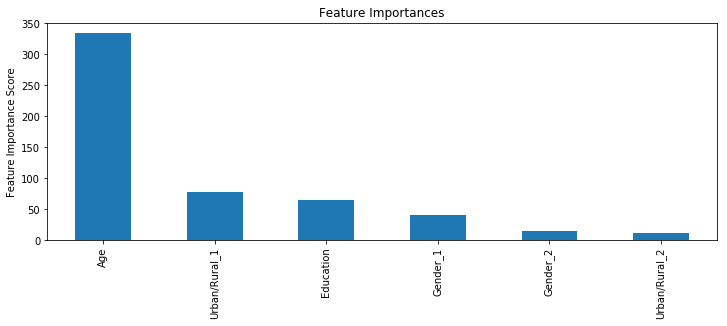

In [20]:
import pandas as pd
import numpy as np
import xgboost as xgb
from xgboost.sklearn import XGBClassifier
import sklearn.metrics as metrics
from sklearn.model_selection import GridSearchCV

import matplotlib.pylab as plt
%matplotlib inline
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 12, 4
target = 'Hypertension'
predictors = [x for x in X_data_train.columns if x not in [target]]

xgb1 = XGBClassifier(
        learning_rate =0.1,
        n_estimators=1000,
        max_depth=5,
        min_child_weight=1,
        gamma=0,
        subsample=0.8,
        colsample_bytree=0.8,
        objective= 'binary:logistic',
        nthread=4,
        scale_pos_weight=1,
        seed=84)
modelfit(xgb1, X_data_train, X_data_test, predictors)

## Grid seach on max_depth and min_child_weight: Initial step

In [ ]:
param_test1 = {
    'max_depth':range(3,10,2),
    'min_child_weight':range(1,10,2)
}
gsearch1 = GridSearchCV(estimator = XGBClassifier(learning_rate=0.1, n_estimators=200, max_depth=5,
                                        min_child_weight=1, gamma=0, subsample=0.8, colsample_bytree=0.8,
                                        objective= 'binary:logistic', nthread=4, scale_pos_weight=1, seed=84), 
                       param_grid = param_test1, scoring='roc_auc',n_jobs=4,iid=False, cv=10)
gsearch1.fit(X_train,y_train)

In [ ]:
print(gsearch1.best_params_)
print(gsearch1.best_score_)
print("#"*100)
#gsearch1.cv_results_,gsearch1.best_params_, gsearch1.best_score_

## Grid seach on max_depth and min_child_weight: Step 2

In [ ]:
param_test2 = {
    'max_depth':[1,2,3,4,5],
    'min_child_weight':[7,8,9,10,11,12]
}
gsearch2 = GridSearchCV(estimator = XGBClassifier(learning_rate =0.1, n_estimators=200, max_depth=3,
                                        min_child_weight=7, gamma=0, subsample=0.8, colsample_bytree=0.8,
                                        objective= 'binary:logistic', nthread=4, scale_pos_weight=1, seed=84), 
                       param_grid = param_test2, scoring='roc_auc',n_jobs=4,iid=False, cv=10)
gsearch2.fit(X_train,y_train)

In [ ]:
print(gsearch2.best_params_)
print(gsearch2.best_score_)
print("#"*100)
#gsearch2.cv_results_,gsearch2.best_params_, gsearch2.best_score_

## Grid seach on max_depth and min_child_weight: Double check

In [ ]:
param_test3 = {
    'max_depth':[1,2,3],
    'min_child_weight':[6,7,8,9,10,11]
}
gsearch3 = GridSearchCV(estimator = XGBClassifier( learning_rate =0.1, n_estimators=200, max_depth=2,
                                        min_child_weight=10, gamma=0, subsample=0.8, colsample_bytree=0.8,
                                        objective= 'binary:logistic', nthread=4, scale_pos_weight=1, seed=84), 
                       param_grid = param_test3, scoring='roc_auc',n_jobs=4,iid=False, cv=10)
gsearch3.fit(X_train,y_train)

In [ ]:
print(gsearch3.best_params_)
print(gsearch3.best_score_)
print("#"*100)
#gsearch3.cv_results_,gsearch3.best_params_, gsearch3.best_score_

## Grid seach on gamma: Initial step

In [ ]:

#Choose all predictors except target & IDcols
param_test4 = {
    'gamma':[i/10.0 for i in range(0,5)]
}
gsearch4 = GridSearchCV(estimator = XGBClassifier(learning_rate =0.1, n_estimators=200, max_depth=1,
                                        min_child_weight=9, gamma=0, subsample=0.8, colsample_bytree=0.8,
                                        objective= 'binary:logistic', nthread=4, scale_pos_weight=1,seed=84), 
                       param_grid = param_test4, scoring='roc_auc',n_jobs=4,iid=False, cv=10)
gsearch4.fit(X_train,y_train)

In [ ]:
print(gsearch4.best_params_)
print(gsearch4.best_score_)
print("#"*100)
# gsearch4.cv_results_,gsearch4.best_params_, gsearch4.best_score_

# Evaluate importance and accuracy

In [ ]:
predictors = [x for x in X_data_train.columns if x not in [target]]
xgb2 = XGBClassifier(
        learning_rate =0.1,
        n_estimators=1000,
        max_depth=2,
        min_child_weight=4,
        gamma=0,
        subsample=0.8,
        colsample_bytree=0.8,
        objective= 'binary:logistic',
        nthread=4,
        scale_pos_weight=1,
        seed=84)
modelfit(xgb2, X_data_train, X_data_test, predictors)

## Grid seach on subsample and colsample_bytree: Initial step

In [ ]:
#Choose all predictors except target & IDcols
param_test5 = {
    'subsample':[i/10.0 for i in range(6,10)],
    'colsample_bytree':[i/10.0 for i in range(6,10)]
}
gsearch5 = GridSearchCV(estimator = XGBClassifier(learning_rate =0.1, n_estimators=200, max_depth=1,
                                        min_child_weight=9, gamma=0.2, subsample=0.8, colsample_bytree=0.8,
                                        objective= 'binary:logistic', nthread=4, scale_pos_weight=1,seed=84), 
                       param_grid = param_test5, scoring='roc_auc',n_jobs=4,iid=False, cv=10)
gsearch5.fit(X_train,y_train)

In [ ]:
print(gsearch5.best_params_)
print(gsearch5.best_score_)
print("#"*100)
#gsearch5.cv_results_,gsearch5.best_params_, gsearch5.best_score_

## Grid seach on subsample and colsample_bytree: Fine-tune

In [ ]:
#Choose all predictors except target & IDcols
param_test6 = {
    'subsample':[i/100.0 for i in range(45,75,5)],
    'colsample_bytree':[i/100.0 for i in range(75,100,5)]
}
gsearch6 = GridSearchCV(estimator = XGBClassifier(learning_rate =0.1, n_estimators=200, max_depth=1,
                                        min_child_weight=9, gamma=0.2, subsample=0.8, colsample_bytree=0.8,
                                        objective= 'binary:logistic', nthread=4, scale_pos_weight=1,seed=84), 
                       param_grid = param_test6, scoring='roc_auc',n_jobs=4,iid=False, cv=10)
gsearch6.fit(X_train,y_train)

In [ ]:
print(gsearch6.best_params_)
print(gsearch6.best_score_)
print("#"*100)
#gsearch6.cv_results_,gsearch6.best_params_, gsearch6.best_score_

## Grid seach on reg_alpha: Initial step

In [ ]:
#Choose all predictors except target & IDcols
param_test7 = {
    'reg_alpha':[1e-5, 1e-2, 0.1, 1, 100]
}
gsearch7 = GridSearchCV(estimator = XGBClassifier(learning_rate=0.1, n_estimators=200, max_depth=1,
                                        min_child_weight=9, gamma=0.2, subsample=0.55, colsample_bytree=0.85,
                                        objective= 'binary:logistic', nthread=4, scale_pos_weight=1,seed=84), 
                       param_grid = param_test7, scoring='roc_auc',n_jobs=4,iid=False, cv=10)
gsearch7.fit(X_train,y_train)

In [ ]:
print(gsearch7.best_params_)
print(gsearch7.best_score_)
print("#"*100)
#gsearch7.cv_results_,gsearch7.best_params_, gsearch7.best_score_

## Grid seach on reg_alpha: Fine-tune

In [ ]:
# Choose all predictors except target & IDcols
param_test8 = {
    'reg_alpha':[1e-7, 5e-7, 1e-6, 5e-6, 1e-5, 5e-4, 1e-4]
}
gsearch8 = GridSearchCV(estimator = XGBClassifier(learning_rate=0.1, n_estimators=200, max_depth=1,
                                        min_child_weight=9, gamma=0.2, subsample=0.55, colsample_bytree=0.85,
                                        objective= 'binary:logistic', nthread=4, scale_pos_weight=1,seed=84), 
                       param_grid = param_test8, scoring='roc_auc',n_jobs=4,iid=False, cv=10)
gsearch8.fit(X_train,y_train)

In [ ]:
print(gsearch8.best_params_)
print(gsearch8.best_score_)
print("#"*100)
# gsearch8.cv_results_,gsearch8.best_params_, gsearch8.best_score_


Model Report
Accuracy : %.4g 0.7142186766776162
AUC Score (Train): 0.6883541991217077]
AUC Score (Test): 0.6998282219627161
gbtree


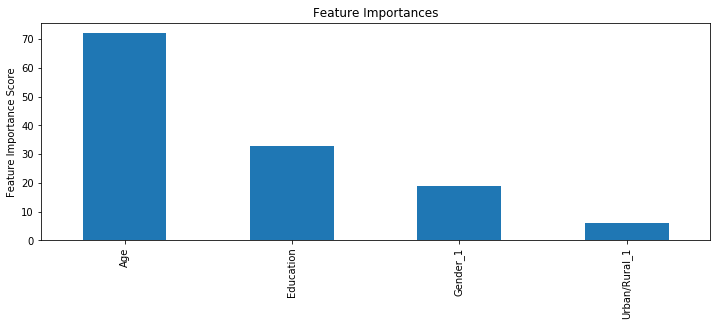

In [21]:
xgb3 = XGBClassifier(
        learning_rate =0.2,
        n_estimators=1000,
        max_depth=1,
        min_child_weight=9,
        gamma=0.2,
        subsample=0.55,
        colsample_bytree=0.85,
        reg_alpha=1e-05,
        objective= 'binary:logistic',
        nthread=4,
        scale_pos_weight=1,
        seed=84)
modelfit(xgb3, X_data_train, X_data_test, predictors)

In [ ]:
X_data_test['Hypertension'] = xgb3.predict_proba(data_svrs2012)[:,1]
X_data_test['Hypertension'] = np.where(data_svrs2012r['Hypertension'] > 0.37, 1, 0)

# Predicting hypertension prevalence using SVRS 2013, 2014 and 2017 data

- SVRS 2012: DBF
- SVRS 2013: SAV
- SVRS 2014: SAV
- SVRS 2015: DBF
- SVRS 2017: DTA

In [ ]:
for var in ncd_data.columns: 
    print(var,len(ncd_data[var].value_counts()))

In [122]:
def eer_threshold(model, test_X, test_y):
    predictions = model.predict_proba(test_X)
    predictions = predictions[:,1]
    output = {}
    for i in range(5,100,1):
        y_predicted = np.where(predictions > i/100, 1, 0)
        cm = confusion_matrix(y_pred=y_predicted, y_true=test_y,)
        tn, fp, fn, tp = cm.ravel()
        n = test_y.value_counts()[0]
        p = test_y.value_counts()[1]
        precision = tp / (tp + fp) # positive predictive value
        recall = tp / (tp + fn) # true positive rate
        output[str(i/100)] = precision-recall
    output = pd.DataFrame.from_dict(output,orient='index', columns=['EER'])
    output['EER'] = np.absolute(output['EER'])
    output = output.sort_values(by='EER', ascending=True)
    display(output.head(10))
    return float(output.index[0]), output.iloc[0,0],
tr = eer_threshold(model=xgb3,test_X=X_test, test_y=y_test)

/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:11: RuntimeWarning: invalid value encountered in long_scalars
  # This is added back by InteractiveShellApp.init_path()


,EER
0.37,0.014171
0.38,0.023623
0.36,0.030962
0.39,0.075610
0.4,0.094649
0.35,0.101741
0.41,0.119382
0.34,0.122538
0.42,0.134369
0.43,0.182154


0.0


0.05473906239368581

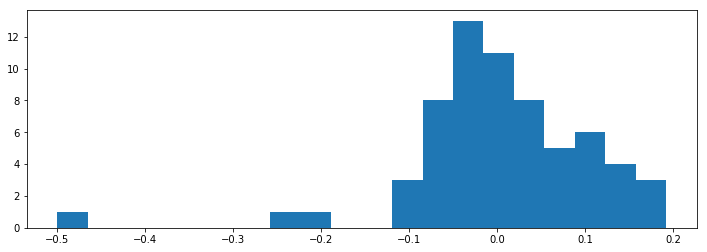

In [126]:
y_predicted = xgb3.predict_proba(X)
y_predicted = y_predicted[:,1]
y_predicted = np.where(y_predicted > 0.37, 1, 0)
eval_prevalence = pd.DataFrame.from_dict({'actual': y, 'predicted': y_predicted, 'district':ncd_data.loc[y.index,'shdistrict']})
eval_prevalence = eval_prevalence.groupby('district').sum()/eval_prevalence.groupby('district').count()
plt.hist(eval_prevalence['actual'] - eval_prevalence['predicted'], bins=20)
print((eval_prevalence['actual'] - eval_prevalence['predicted']).median())
eval_prevalence['difference'] = np.absolute(eval_prevalence['actual'] - eval_prevalence['predicted'])
eval_prevalence['difference'].median()

-0.00942712110224797


0.037763752020290746

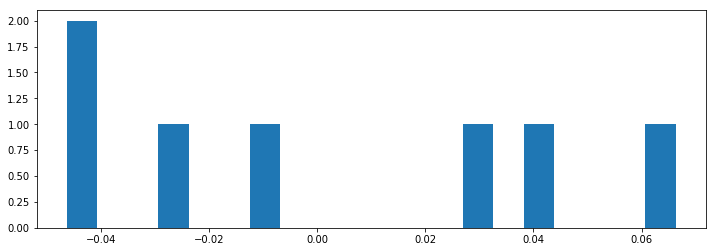

In [128]:
y_predicted = xgb3.predict_proba(X)
y_predicted = y_predicted[:,1]
y_predicted = np.where(y_predicted > 0.37, 1, 0)
eval_prevalence = pd.DataFrame.from_dict({'actual': y, 'predicted': y_predicted, 'district':ncd_data.loc[y.index,'hv024']})
eval_prevalence = eval_prevalence.groupby('district').sum()/eval_prevalence.groupby('district').count()
plt.hist(eval_prevalence['actual'] - eval_prevalence['predicted'], bins=20)
print((eval_prevalence['actual'] - eval_prevalence['predicted']).median())
eval_prevalence['difference'] = np.absolute(eval_prevalence['actual'] - eval_prevalence['predicted'])
eval_prevalence['difference'].mean()

In [129]:
y_predicted = xgb3.predict_proba(X_test)
y_predicted = y_predicted[:,1]
y_predicted = np.where(y_predicted > 0.37, 1, 0)
cm1= pd_ml.ConfusionMatrix(y_pred=y_predicted, y_true=y_test,)
cm2 = confusion_matrix(y_pred=y_predicted, y_true=y_test,)
print(cm2)

[[853 254]
 [240 252]]


In [130]:
from sklearn.metrics import average_precision_score
print(classification_report(y_test, y_predicted))

              precision    recall  f1-score   support

           0       0.78      0.77      0.78      1107
           1       0.50      0.51      0.51       492

   micro avg       0.69      0.69      0.69      1599
   macro avg       0.64      0.64      0.64      1599
weighted avg       0.69      0.69      0.69      1599



In [131]:
import os
import sys
import glob
import tzlocal
import numpy as np
import pandas as pd
from scipy import io
from dbfread import DBF
from collections import Counter
import matplotlib.pyplot as plt
import rpy2.robjects as robjects
from rpy2.robjects import packages
from rpy2.robjects import pandas2ri
from simpledbf import Dbf5
from dbfread import DBF

def read_dbf(file):
    tmp = DBF(file)
    tmp = pd.DataFrame(iter(tmp))
    return tmp

def read_sav(file):
    foreign = packages.importr('foreign')
    pandas2ri.activate()
    df = foreign.read_spss(file, reencode=False)
    return pd.DataFrame(dict(zip(df.names, map(list,list(df)))))

def read_svrs(file):
    itr = pd.read_stata(file, iterator=True)
    variables = list(itr.variable_labels().values())
    data = pd.read_stata(os.path.join(file))
    original_variables = list(data.columns)
    data.columns = variables
    return data, original_variables

In [132]:
SVRS2012 = '/Users/edinhamzic/Symphony/wb_bangladesh/Bangladesh/data/bbs/svrs/SVRS_12/tafsil-2p.dbf'
SVRS2013 = '/Users/edinhamzic/Symphony/wb_bangladesh/Bangladesh/data/bbs/svrs/SVRS_13/pop_hh_14-05-2015.sav'
SVRS2014 = '/Users/edinhamzic/Symphony/wb_bangladesh/Bangladesh/data/bbs/svrs/SVRS_14/tafsil2P_12-06-2015.sav'
SVRS2015 = '/Users/edinhamzic/Symphony/wb_bangladesh/Bangladesh/data/bbs/svrs/SVRS_15/tafsil-2p.dbf'
SVRS2017 = '/Users/edinhamzic/Symphony/wb_bangladesh/Bangladesh/data/bbs/svrs/SVRS_17/tafsl-2p.dta'
variables = ['Education', 'Age', 'Urban/Rural', 'Gender']

## SVRS2012

In [133]:
data_svrs2012r = read_dbf(SVRS2012)
data_svrs2012 = data_svrs2012r.copy(deep=True)
data_svrs2012 = data_svrs2012r[['Q_16', 'Q_11', 'RMO', 'Q_12']]
data_svrs2012.columns = variables
data_svrs2012 = data_svrs2012[data_svrs2012['Education'] != 99]
data_svrs2012r = data_svrs2012r[data_svrs2012r['Q_16'] != 99]
data_svrs2012['Urban/Rural'] = np.where(data_svrs2012['Urban/Rural'] != '1', 2, 1)
data_svrs2012['Urban/Rural'] = data_svrs2012['Urban/Rural'].astype(int).astype('category')
data_svrs2012['Gender'] = data_svrs2012['Urban/Rural'].astype(int).astype('category')

In [134]:
data_svrs2012 = pd.get_dummies(data_svrs2012)
data_svrs2012.head()

,Education,Age,Urban/Rural_1,Urban/Rural_2,Gender_1,Gender_2
0,10,60,1,0,1,0
1,8,41,1,0,1,0
2,8,14,1,0,1,0
3,11,19,1,0,1,0
4,5,48,1,0,1,0


## SVRS2013

In [135]:
# data_svrs2013r = read_sav(SVRS2013)
# print(data_svrs2013.columns)
# print(data_svrs2013['Q11'].value_counts().sort_index()) # Age
# print(data_svrs2013['Q12'].value_counts().sort_index()) # Sex
# !!! Education correction: print(data_svrs2013['Q16'].value_counts()) # Education
# !!! print(data_svrs2013['RMO'].value_counts()) # Have to check three levels: of RMO

## SVRS2014

In [136]:
# print(data_svrs2014.columns)
# print(data_svrs2014['Q11'].value_counts().sort_index()) # Age
# print(data_svrs2014['Q16'].value_counts().sort_index()) # Education
# print(data_svrs2014['Q12'].value_counts()) # Sex
# print(data_svrs2014['RMO'].value_counts()) # Have to check three levels: of RMO

In [137]:
data_svrs2014r = read_sav(SVRS2014)
data_svrs2014 = data_svrs2014r.copy(deep=True)
data_svrs2014 = data_svrs2014[data_svrs2014['Q16'].notna()]
data_svrs2014 = data_svrs2014[data_svrs2014['Q16'] != 'Other']
data_svrs2014 = data_svrs2014[data_svrs2014['Q16'] != '4.05']
data_svrs2014 = data_svrs2014[data_svrs2014['Q16'] != '99']
data_svrs2014 = data_svrs2014[['Q16', 'Q11', 'RMO', 'Q12']]
data_svrs2014.columns = variables
data_svrs2014['Education'] = data_svrs2014['Education'].astype(int)
data_svrs2014['Age'] = data_svrs2014['Age'].astype(int)
data_svrs2014['Urban/Rural'] = np.where(data_svrs2014['Urban/Rural'] != 'Rural', 2, 1)
print(data_svrs2014['Urban/Rural'].value_counts())
data_svrs2014['Urban/Rural'] = data_svrs2014['Urban/Rural'].astype(int).astype('category')
data_svrs2014['Gender'] = np.where(data_svrs2014['Gender'] == 'Male', 1, 2)
data_svrs2014['Gender'] = data_svrs2014['Gender'].astype(int).astype('category')
data_svrs2014 = data_svrs2014[data_svrs2014['Education'] != 99]
data_svrs2014r = data_svrs2014r[data_svrs2014r['Q16'].notna()]
data_svrs2014r = data_svrs2014r[data_svrs2014r['Q16'] != 'Other']
data_svrs2014r = data_svrs2014r[data_svrs2014r['Q16'] != '4.05']
data_svrs2014r = data_svrs2014r[data_svrs2014r['Q16'] != '99']
data_svrs2014 = pd.get_dummies(data_svrs2014)
data_svrs2014.head()

1    340701
2    276382
Name: Urban/Rural, dtype: int64


,Education,Age,Urban/Rural_1,Urban/Rural_2,Gender_1,Gender_2
0,13,52,0,1,1,0
1,9,42,0,1,0,1
2,5,12,0,1,1,0
3,10,20,0,1,1,0
4,11,27,0,1,1,0


## SVRS2015

In [138]:
# print(data_svrs2015.columns)
# print(data_svrs2015['Q_11'].value_counts().sort_index()) # Sex
# print(data_svrs2015['Q_10'].value_counts().sort_index()) # Age
# print(data_svrs2015['Q_16'].value_counts().sort_index()) # Education
# print(data_svrs2015['RMO'].value_counts()) # Have to check three levels: of RMO

In [139]:
data_svrs2015r = read_dbf(SVRS2015)
data_svrs2015 = data_svrs2015r.copy(deep=True)
print(variables)
data_svrs2015 = data_svrs2015[['Q_16', 'Q_10', 'RMO', 'Q_11']]
data_svrs2015.columns = variables
data_svrs2015 = data_svrs2015[data_svrs2015['Education'] != 99]
print(data_svrs2015.dtypes)
print(data_svrs2015['Urban/Rural'].value_counts())
data_svrs2015['Urban/Rural'] = np.where(data_svrs2015['Urban/Rural'] != '1', 2, 1)
print(data_svrs2015['Urban/Rural'].value_counts())
data_svrs2015['Urban/Rural'] = data_svrs2015['Urban/Rural'].astype(int).astype('category')
data_svrs2015['Gender'] = data_svrs2015['Gender'].astype(int).astype('category')
data_svrs2015 = data_svrs2015[data_svrs2015['Education'] != 99]
data_svrs2015r = data_svrs2015r[data_svrs2015r['Q_16'] != 99]
data_svrs2015 = pd.get_dummies(data_svrs2015)
data_svrs2015.head()

['Education', 'Age', 'Urban/Rural', 'Gender']
Education       int64
Age             int64
Urban/Rural    object
Gender          int64
dtype: object
1    566180
2    215170
3    136643
4     20425
Name: Urban/Rural, dtype: int64
1    566180
2    372238
Name: Urban/Rural, dtype: int64


,Education,Age,Urban/Rural_1,Urban/Rural_2,Gender_1,Gender_2
0,13,53,0,1,1,0
1,9,43,0,1,0,1
2,6,13,0,1,1,0
3,10,21,0,1,1,0
4,7,46,0,1,1,0


## SVRS2017

In [140]:
# print(data_svrs2017.columns)
# print(data_svrs2017['Q_11'].value_counts().sort_index()) # Sex
# print(data_svrs2017['Q_10'].value_counts().sort_index()) # Age
# print(data_svrs2017['Q_16'].value_counts().sort_index()) # Education
# print(data_svrs2017['RMO'].value_counts()) # Have to check three levels: of RMO

In [141]:
data_svrs2017r, original_variables = read_svrs(SVRS2017)
data_svrs2017 = data_svrs2017r[['  Level of Education', '  Age', '  Rural Urban code','  Sex']]
variables = ['Education', 'Age', 'Urban/Rural', 'Gender']
data_svrs2017.columns = variables
print(data_svrs2017.shape)
data_svrs2017 = data_svrs2017[data_svrs2017['Urban/Rural'] != 9]
data_svrs2017 = data_svrs2017[data_svrs2017['Urban/Rural'] != 3]
data_svrs2017 = data_svrs2017[data_svrs2017['Education'] != 99]
data_svrs2017r = data_svrs2017r[data_svrs2017r['  Rural Urban code'] != 9]
data_svrs2017r = data_svrs2017r[data_svrs2017r['  Rural Urban code'] != 3]
data_svrs2017r = data_svrs2017r[data_svrs2017r['  Level of Education'] != 99]
data_svrs2017['Urban/Rural'] = data_svrs2017['Urban/Rural'].astype(int).astype('category')
print(data_svrs2017['Urban/Rural'].value_counts())
print(data_svrs2017['Gender'].value_counts())
data_svrs2017['Gender'] = data_svrs2017['Gender'].astype(int).astype('category')
data_svrs2017 = pd.get_dummies(data_svrs2017)
print(data_svrs2017.shape)
data_svrs2017.head()

(1252581, 4)
1    699584
2    210929
Name: Urban/Rural, dtype: int64
1.0    455602
2.0    454911
Name: Gender, dtype: int64
(910513, 6)


,Education,Age,Urban/Rural_1,Urban/Rural_2,Gender_1,Gender_2
0,10.0,22.0,0,1,1,0
1,8.0,12.0,0,1,1,0
2,13.0,55.0,0,1,0,1
3,9.0,45.0,0,1,0,1
4,7.0,53.0,0,1,1,0


# Prediting hypertension and writing results out

In [142]:
data_svrs2012r['Hypertension'] = xgb3.predict_proba(data_svrs2012)[:,1]
data_svrs2012r['Hypertension'] = np.where(data_svrs2012r['Hypertension'] > 0.37, 1, 0)
data_svrs2014r['Hypertension'] = xgb3.predict_proba(data_svrs2014)[:,1]
data_svrs2014r['Hypertension'] = np.where(data_svrs2014r['Hypertension'] > 0.37, 1, 0)
data_svrs2015r['Hypertension'] = xgb3.predict_proba(data_svrs2015)[:,1]
data_svrs2015r['Hypertension'] = np.where(data_svrs2015r['Hypertension'] > 0.37, 1, 0)
data_svrs2017r['Hypertension'] = xgb3.predict_proba(data_svrs2017)[:,1]
data_svrs2017r['Hypertension'] = np.where(data_svrs2017r['Hypertension'] > 0.37, 1, 0)

In [ ]:
print(f"Predictions for 2012:\n {data_svrs2012r['Hypertension'].value_counts()/data_svrs2012r.shape[0]*100}")
print(f"Predictions for 2014:\n {data_svrs2014r['Hypertension'].value_counts()/data_svrs2014r.shape[0]*100}")
print(f"Predictions for 2015:\n {data_svrs2015r['Hypertension'].value_counts()/data_svrs2015r.shape[0]*100}")
print(f"Predictions for 2017:\n {data_svrs2017r['Hypertension'].value_counts()/data_svrs2017r.shape[0]*100}")

# Writing results out

In [ ]:
OUT = '/Users/edinhamzic/Symphony/wb_bangladesh/Bangladesh/output/ncd/'

## Writing out 2012

In [ ]:
data_svrs2012r["DIVN_ZILA"] = data_svrs2012r["DIVN"].str.cat(data_svrs2012r["ZILA"])
tmp1 = data_svrs2012r[["DIVN_ZILA", "Hypertension"]].groupby('DIVN_ZILA').sum().reset_index()
tmp1.columns = ["DIVN_ZILA", "Hypertension count"]
tmp2 = data_svrs2012r[["DIVN_ZILA", "Hypertension"]].groupby('DIVN_ZILA').count().reset_index()
tmp2.columns = ["DIVN_ZILA", "Total count"]
tmp = tmp1.merge(tmp2, how='left', on='DIVN_ZILA')
tmp['Hypertension prevalence'] = np.round(tmp['Hypertension count']/tmp['Total count']*100,2)
tmp.to_csv(OUT +'/hypertension_prevalence_2012.csv', index=False, index_label=False)
tmp.head()

## Writing out 2014

In [ ]:
data_svrs2014r["DIVN_ZILA"] = data_svrs2014r["zila"]
tmp1 = data_svrs2014r[["DIVN_ZILA", "Hypertension"]].groupby('DIVN_ZILA').sum().reset_index()
tmp1.columns = ["DIVN_ZILA", "Hypertension count"]
tmp2 = data_svrs2014r[["DIVN_ZILA", "Hypertension"]].groupby('DIVN_ZILA').count().reset_index()
tmp2.columns = ["DIVN_ZILA", "Total count"]
tmp = tmp1.merge(tmp2, how='left', on='DIVN_ZILA')
tmp['Hypertension prevalence'] = np.round(tmp['Hypertension count']/tmp['Total count']*100,2)
tmp.to_csv(OUT +'/hypertension_prevalence_2014.csv', index=False, index_label=False)
tmp.head()


## Writing out 2015

In [ ]:
data_svrs2015r["DIVN_ZILA"] = data_svrs2015r["ZILA"]
tmp1 = data_svrs2015r[["DIVN_ZILA", "Hypertension"]].groupby('DIVN_ZILA').sum().reset_index()
tmp1.columns = ["DIVN_ZILA", "Hypertension count"]
tmp2 = data_svrs2015r[["DIVN_ZILA", "Hypertension"]].groupby('DIVN_ZILA').count().reset_index()
tmp2.columns = ["DIVN_ZILA", "Total count"]
tmp = tmp1.merge(tmp2, how='left', on='DIVN_ZILA')
tmp['Hypertension prevalence'] = np.round(tmp['Hypertension count']/tmp['Total count']*100,2)
tmp.to_csv(OUT +'/hypertension_prevalence_2015.csv', index=False, index_label=False)
tmp.head()

## Writing out 2017

In [ ]:
data_svrs2017r["DIVN_ZILA"] = data_svrs2017r["Zila code"].astype(int).astype(str)
data_svrs2017r["DIVN_ZILA"] = data_svrs2017r["DIVN_ZILA"].str.pad(width=2, side='left', fillchar='0')
tmp1 = data_svrs2017r[["DIVN_ZILA", "Hypertension"]].groupby('DIVN_ZILA').sum().reset_index()
tmp1.columns = ["DIVN_ZILA", "Hypertension count"]
tmp2 = data_svrs2017r[["DIVN_ZILA", "Hypertension"]].groupby('DIVN_ZILA').count().reset_index()
tmp2.columns = ["DIVN_ZILA", "Total count"]
tmp = tmp1.merge(tmp2, how='left', on='DIVN_ZILA')
tmp['Hypertension prevalence'] = np.round(tmp['Hypertension count']/tmp['Total count']*100,2)
tmp.to_csv(OUT +'/hypertension_prevalence_2017.csv', index=False, index_label=False)
tmp.head()